# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

**Цель исследования:**

1. Проанализировать и обработать предложенные данные
2. Подобрать наиболее точную и адекватную можель для обучения
3. Протестировать ее на тестовой выборке
4. На основе проделанной работы предложить Банку оптимальную модель для прогнозирования

**Ход исследования**

Данные клиентах в файле "Churn.csv". О качестве данных ничего не известно. Поэтому перед тем, как приступать к целям исследования, понадобится обзор данных

Я проверю данные на ошибки и оценю их влияние на исследование. Затем, на этапе предобработки я поищу возможность исправить все ошибки данных, которые не приведут к искажению конечного результата. Далее, создам необходимое количество дополнительных колонок и таблиц, и приступлю к проведению анализа

Анализ в свою очередь пройдет в два этапа:

1. Обзор моделей на несбалансированной выборке
2. Исследование вариантов борьба с дисбалансом для достижения максимальных метрик адексатности модели

Завершающий этап -- тестирование модели, которая показала наилучшие результаты

Таким образом, моё исследование пройдёт в шесть этапов:

 - Обзор данных
 - Предобработка данных
 - Исследование без учета дизбаланса
 - Исследование с учетом дисбаланса
 - Тестирование
 - Общий вывод

**Описание данных:**

* **Признаки**
    - **RowNumber** — индекс строки в данных
    - **CustomerId** — уникальный идентификатор клиента
    - **Surname** — фамилия
    - **CreditScore** — кредитный рейтинг
    - **Geography** — страна проживания
    - **Gender** — пол
    - **Age** — возраст
    - **Tenure** — сколько лет человек является клиентом банка
    - **Balance** — баланс на счёте
    - **NumOfProducts** — количество продуктов банка, используемых клиентом
    - **HasCrCard** — наличие кредитной карты
    - **IsActiveMember** — активность клиента
    - **EstimatedSalary** — предполагаемая зарплата
* **Целевой признак**
    - **Exited** — факт ухода клиента

In [1]:
import pandas as pd
import numpy as np
import re 
import warnings
import time

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle 
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import classification_report, f1_score, roc_curve, precision_recall_curve, roc_auc_score 

In [2]:
warnings.filterwarnings('ignore') # отключаем предупреждения
RAND_FIX = 12345 # Зафиксируем random_state

## Шаг 1 Подготовка данных

### 1.1 Открыть и изучить данные

In [3]:
try:
    d_cust = pd.read_csv('datasets/Churn.csv', sep=',') # загружаем с локального хранилища
    display(d_cust.head(5))
    print()
    d_cust.info()
except:
    d_cust = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv', sep=',') # если что-то не выходит, то с Яндекса
    print('Файл загружен из хранилища Яндекс')
    display(d_cust.head(5))
    print()
    d_cust.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


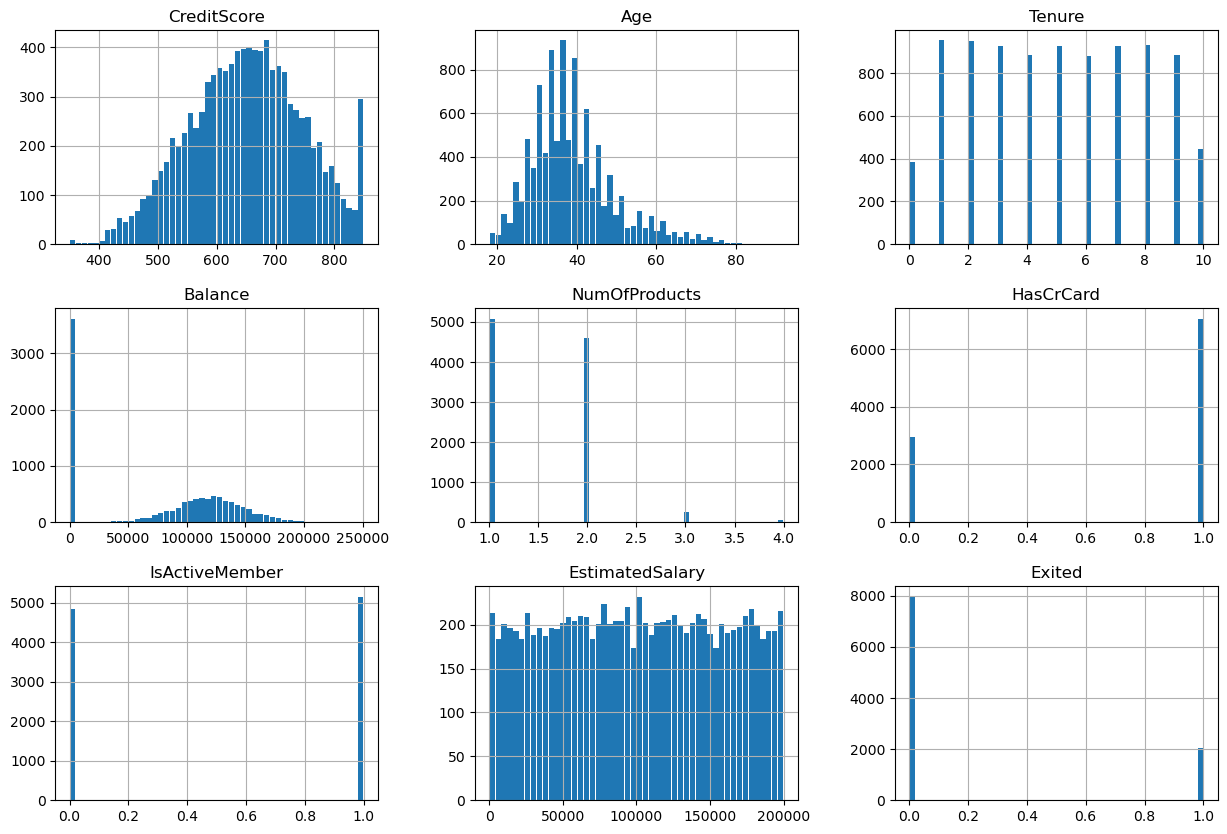

In [4]:
d_cust.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1).hist(rwidth= 0.9, bins = 50, figsize=(15, 10));

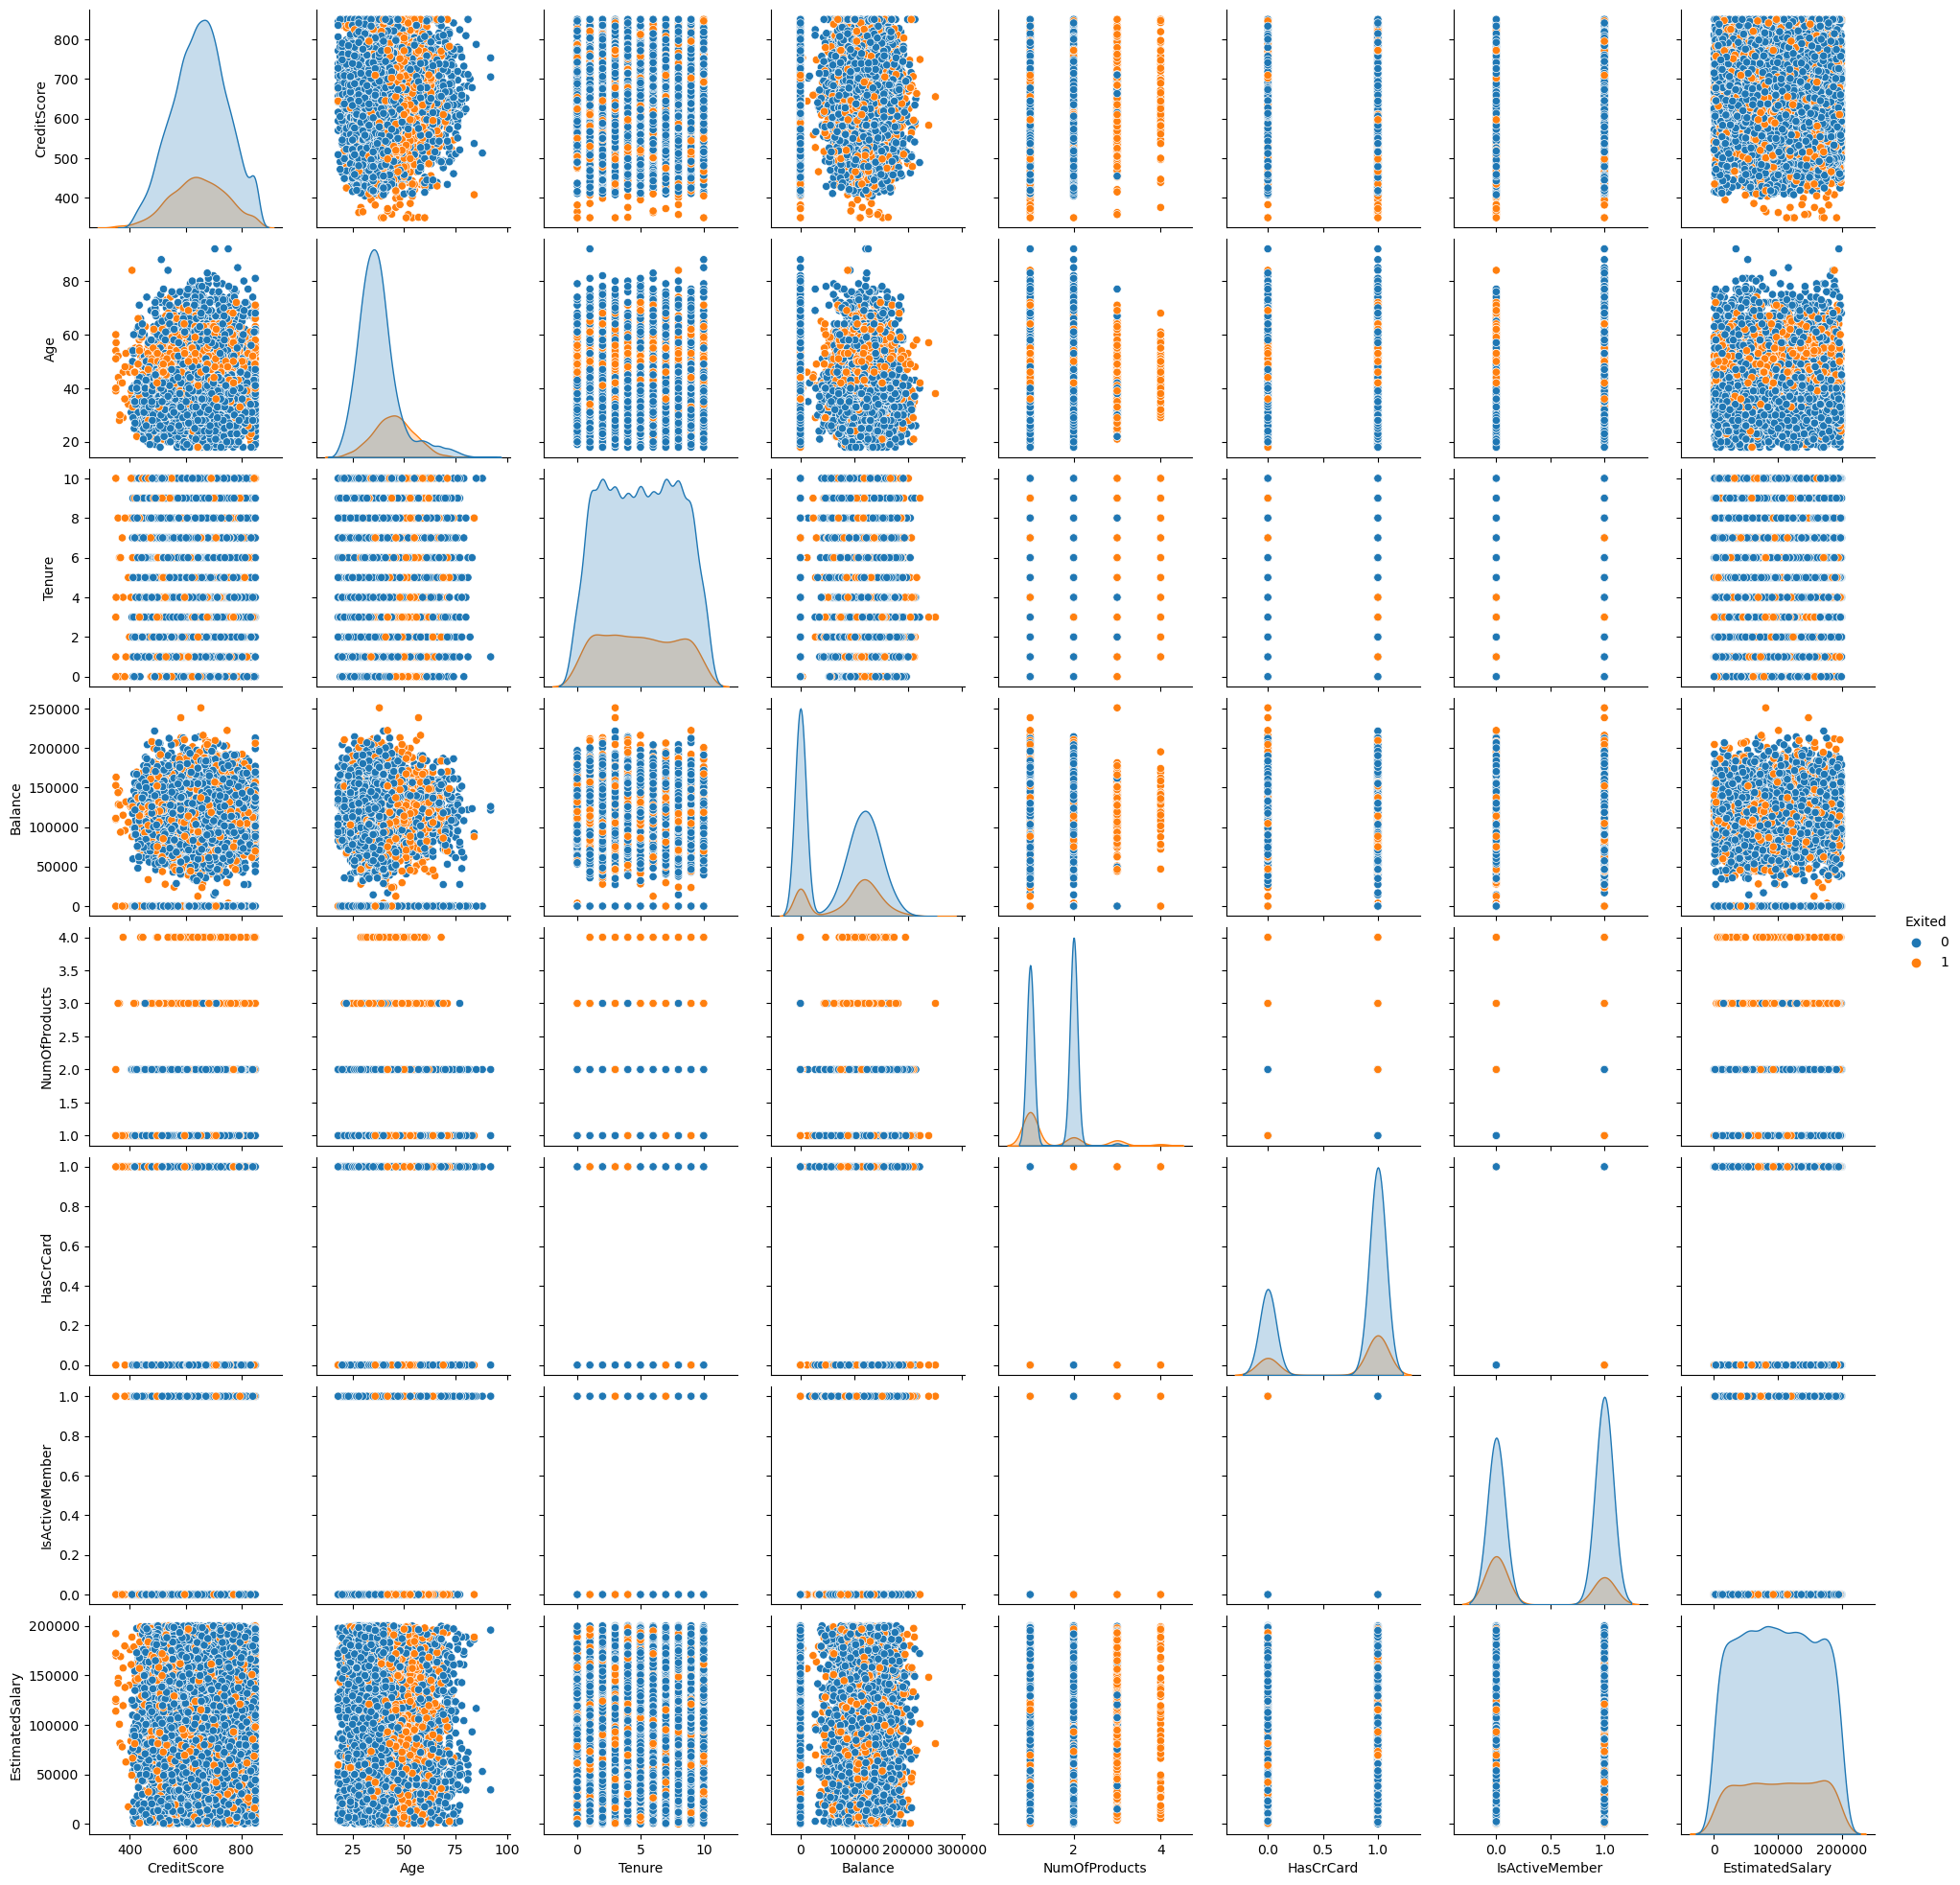

In [5]:
sns.pairplot(data=d_cust.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1), hue="Exited");

С данными нужно поработать:

1. Переименовать колонки
2. Снести колонку RowNumber -- она бесполезна, дублирует индекс датафрейма
3. Проверить на дубли колонку CustomerId
4. Проверить на неявные дубли колонки Geography и Gender, если всё ок, то 
5. Посмотреть пристально на колонку Surname, не особо понятно, как она нам поможет обучить модель
6. Посмотреть пристально на колонку Tenure, там девять процентов пропусков
7. Распределение значений и типы в порядке, тут ничего не трогаем

### 1.2 Предобработка

#### 1.2.1 Переименовываем колонки

In [6]:
d_cust.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in d_cust.columns]
d_cust.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

#### 1.2.2 Удаление row_number

In [7]:
d_cust = d_cust.drop('row_number', axis=1)
d_cust.head(2)

,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0


#### 1.2.3 Проверка на дубли колонки customer_id

In [8]:
d_cust.duplicated('customer_id').sum()

0

Всё ок, дубликатов нет, колоку сносим, она не нужна для обучения модели.

In [9]:
d_cust = d_cust.drop('customer_id', axis=1)
d_cust.head(2)

,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0


#### 1.2.4 Проверка на неявные дубли колонок geography и gender

In [10]:
display(d_cust['geography'].unique())
display(d_cust['gender'].unique())

array(['France', 'Spain', 'Germany'], dtype=object)

array(['Female', 'Male'], dtype=object)

Всё отлично, после исследования surname развернем эти колонки с помощью прямого кодирования с дропом первого столбца

#### 1.2.5 Исследование колонки surname

In [11]:
d_cust.groupby('surname')['surname'].count().sort_values(ascending=False).head(10)

surname
Smith       32
Martin      29
Scott       29
Walker      28
Brown       26
Shih        25
Genovese    25
Yeh         25
Wright      24
Maclean     24
Name: surname, dtype: int64

Как и ожидалось -- распространенные фамилии существуют. Это не критично, отражает окружающую действительность.

Так или иначе, сносим эту колонку, в рамках текущего исследования она бесполезна, а обилие однофамильцев может нашей модели даже и навредить.

In [12]:
d_cust = d_cust.drop('surname', axis=1)
d_cust.head(2)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0


#### 1.2.6 Исследование колонки tenure

Пропусков неприлично много -- девять процентов. Заполнить не представляется возможным -- при изучении данных наглядные зависимости не были обнаружены.  
Можно сойти с ума и:

1. Выделить отдельную выборку, где заполнены значения tenure (без столбца exited)
2. Сказать, что наш целевой показатель -- tenure
3. Подобрать модель которая выдаст наилучшие результаты
4. Обучить/проверить/протестировать модель на 9091 строчках, где заполнено tenure
5. предсказать значение tenure на незаполненных строках

Но мы в рамках этого исследования делать не будем, так как это, по большому счету, дублирование текущего проекта, только на задаче регрессии, а не классификации, как у нас сейчас.  
В жизни я бы предложил лиду/PM-у такой подход, но предупредил бы, что будет +8 человеко-часов. Могут и согласовать =))  

Так или иначе, посмотрим, как распределены данные в случае пустых tenure и визуально сравним с распределением по полной выборке:

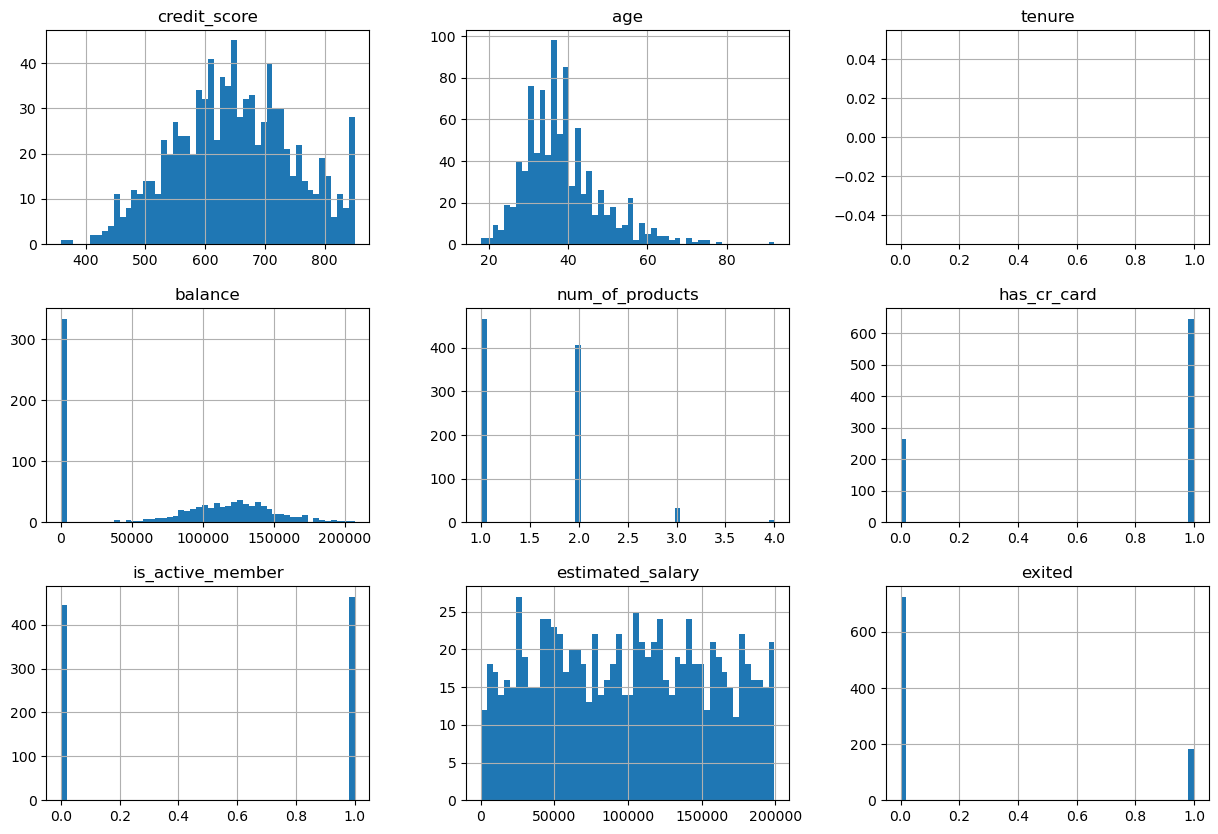

In [13]:
d_cust.loc[d_cust['tenure'].isna(), :].hist(bins=50, figsize=(15, 10));

Распределения очень похожи -- тот же пик на максимальном кредитном рейтинге, множество клиентов с нулевым балансом, распределение по возрасту, балансу и остальным атрибутам тоже похожи.

Чтоб не терять данные, заполняем медианой:

In [14]:
d_cust = d_cust.fillna(d_cust['tenure'].median())
d_cust['tenure'] = d_cust['tenure'].astype('int')

#### 1.2.7 Преобразование geography и gender методом прямого кодирования

In [15]:
d_cust = pd.get_dummies(d_cust, drop_first=True)
d_cust.head(5)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited,geography_Germany,geography_Spain,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


#### 1.2.8 Смотрим на баланс

In [16]:
print('Мощность положительного класса --', d_cust.exited.mean(), 'мощность отрицательного класса --', 1 - d_cust.exited.mean())

Мощность положительного класса -- 0.2037 мощность отрицательного класса -- 0.7963


Действительно, разница примерно один к четырем, нужно будет балансировать.

#### 1.2.9 Разрезаем датафрейм на подмножества

Отдельной тестовой выборки у нас нет, поэтому делим датасет на train, test и valid в пропорциях 60 - 20 - 20 соответственно.

In [17]:
target = d_cust.loc[:, 'exited']
features = d_cust.drop('exited', axis=1)

features_train, features_temp, target_train, target_temp =\
train_test_split(features, target, test_size=0.4, random_state=RAND_FIX) 

features_valid, features_test, target_valid, target_test =\
train_test_split(features_temp, target_temp, test_size=0.5, random_state=RAND_FIX) 

print('features_train:', features_train.shape, ' target_train:', target_train.shape)
print('Мощность положительного класса --', target_train.mean(), 'мощность отрицательного класса --', 1 - target_train.mean())
print('features_valid:', features_valid.shape, ' target_valid:', target_valid.shape)
print('Мощность положительного класса --', target_valid.mean(), 'мощность отрицательного класса --', 1 - target_valid.mean())
print('features_test:', features_test.shape, ' target_test:', target_test.shape)
print('Мощность положительного класса --', target_test.mean(), 'мощность отрицательного класса --', 1 - target_test.mean())

features_train: (6000, 11)  target_train: (6000,)
Мощность положительного класса -- 0.19933333333333333 мощность отрицательного класса -- 0.8006666666666666
features_valid: (2000, 11)  target_valid: (2000,)
Мощность положительного класса -- 0.209 мощность отрицательного класса -- 0.791
features_test: (2000, 11)  target_test: (2000,)
Мощность положительного класса -- 0.2115 мощность отрицательного класса -- 0.7885


Баланс выборок изменился от train к test, попробуем зафиксировать стратификацию:

In [18]:
features_train, features_temp, target_train, target_temp =\
train_test_split(features, target, test_size=0.4, random_state=RAND_FIX, stratify=target) 

features_valid, features_test, target_valid, target_test =\
train_test_split(features_temp, target_temp, test_size=0.5, random_state=RAND_FIX, stratify=target_temp) 

print('features_train:', features_train.shape, ' target_train:', target_train.shape)
print('Мощность положительного класса --', target_train.mean(), 'мощность отрицательного класса --', 1 - target_train.mean())
print('features_valid:', features_valid.shape, ' target_valid:', target_valid.shape)
print('Мощность положительного класса --', target_valid.mean(), 'мощность отрицательного класса --', 1 - target_valid.mean())
print('features_test:', features_test.shape, ' target_test:', target_test.shape)
print('Мощность положительного класса --', target_test.mean(), 'мощность отрицательного класса --', 1 - target_test.mean())

features_train: (6000, 11)  target_train: (6000,)
Мощность положительного класса -- 0.20366666666666666 мощность отрицательного класса -- 0.7963333333333333
features_valid: (2000, 11)  target_valid: (2000,)
Мощность положительного класса -- 0.204 мощность отрицательного класса -- 0.796
features_test: (2000, 11)  target_test: (2000,)
Мощность положительного класса -- 0.2035 мощность отрицательного класса -- 0.7965


Теперь корректно.

#### 1.2.9 Проводим масштабирование признаков

Выделим численные признаки, обучим скейлер и применим к features_train и features_valid  
Тестовую выборку трогать не будем

In [19]:
numeric = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']

scaler = StandardScaler()
scaler.fit(features_train.loc[:, numeric])
features_train.loc[:, numeric] = scaler.transform(features_train.loc[:, numeric])

features_valid.loc[:, numeric] = scaler.transform(features_valid.loc[:, numeric])

features_test.loc[:, numeric] = scaler.transform(features_test.loc[:, numeric])

In [20]:
display(features_train.head(5))
display(features_valid.head(5))
display(features_test.head(5))

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
2837,-1.040434,0.953312,0.360600,0.774657,-0.914708,0,1,-0.119110,True,False,False
9925,0.454006,-0.095244,-0.002786,1.910540,-0.914708,1,1,-0.258658,False,False,False
8746,0.103585,-0.476537,1.087371,0.481608,0.820981,0,1,1.422836,False,False,True
660,-0.184996,0.190726,-0.002786,0.088439,-0.914708,1,1,-1.160427,True,False,False
3610,-0.720933,1.620574,-1.456328,0.879129,-0.914708,1,0,0.113236,False,False,False


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
6612,-1.524838,2.383160,-0.729557,1.011655,-0.914708,0,1,0.010275,False,False,False
519,0.587990,1.811221,0.360600,0.213192,-0.914708,0,1,0.453089,False,False,True
1609,-0.318980,-0.381213,1.087371,0.893896,-0.914708,1,0,-0.603508,False,False,False
3475,1.226991,-0.762506,-0.366172,-0.240363,0.820981,1,1,-1.621460,False,False,True
2707,-0.133464,-0.095244,-0.729557,0.447305,-0.914708,0,0,0.338574,False,False,False


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
657,-0.504497,1.429928,-1.456328,0.873883,0.820981,1,1,1.725255,True,False,False
2083,-1.195031,-1.429769,-1.456328,-1.219673,-0.914708,1,1,1.203665,False,False,True
3234,-1.267176,0.762665,-1.456328,-1.219673,-0.914708,1,0,-1.374743,False,False,True
1551,0.825039,1.239281,0.723985,-1.219673,0.820981,0,1,0.382306,False,True,False
2344,0.660135,0.953312,-0.366172,0.267087,-0.914708,1,0,-1.613578,True,False,False


Итого за предобработку мы:

1. Переименовали столбцы
2. Удалили row_number, cistomer_id и surname
3. Преобразовали geography и gender методом прямого кодирования с дропом первого столбца
4. Разбили данные на обучающую, валидационную и тестовую выборки
5. Отмасштабировали численные признаки
6. Заполнили пропуски в tenure медианой

## Шаг 2 Исследование задачи

Исследуем модели:

 - дерево решений
 - случайный лес
 - логистическую регрессию
 
 На текущий момент мы будем тспользовать несбалансированную выборку.
 
 определим функцию для подбора глобальных парамтеров под каждую модель:

In [21]:
def goodness_of_fit_and_roc_auc (f_train, t_train, f_valid, t_valid):
    
# Определим результирующие параметры для моделей:
# f -- случайный лес
# t -- дерево реений
# l -- логистическая регрессия
    
    best_model_for_f = None
    best_result_for_f = 0
    best_est_for_f = 0
    best_depth_for_f = 0
    
    best_model_for_l = None
    best_result_for_l = 0
    best_alg_for_l = None
    alg = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
    
    best_model_for_t = None
    best_result_for_t = 0
    best_depth_for_t = 0
    
    
    # Цикл для подборки глубины и количества деревьев случайного леса:
    for est in range(10, 301, 10):
        for depth in range (4, 50):
            start_time = time.time()
            model = RandomForestClassifier(random_state=RAND_FIX, n_estimators=est, max_depth=depth)  # Инициируем модель
            model.fit(f_train, t_train)     # Учим модель
            end_time = time.time()
            pred_val_f = model.predict(f_valid)
            result = f1_score(t_valid, pred_val_f)
            if result > best_result_for_f:
                best_model_for_f = model
                best_result_for_f = result
                best_est_for_f = est
                best_depth_for_f = depth
                est_time_for_f = end_time - start_time

    # Цикл для подборки глубины дерева решений:  
    for depth in range(4, 50):
        start_time = time.time()
        model = DecisionTreeClassifier(max_depth=depth, random_state=RAND_FIX) # Инициируем модель
        model.fit(f_train, t_train)    # Учим модель
        end_time = time.time()
        pred_val_t = model.predict(f_valid)
        result = f1_score(t_valid, pred_val_t)
        if result > best_result_for_t:
            best_result_for_t = result
            est_time_for_t = end_time - start_time
            best_depth_for_t = depth
            best_model_for_t = model

    # Цикл для подборки алгоритма:
    for i in range(5):
        start_time = time.time()
        model = LogisticRegression(random_state=RAND_FIX, solver=alg[i], max_iter=1000)  # Инициируем модель
        model.fit(f_train, t_train)        # Учим модель
        end_time = time.time()
        pred_val_l = model.predict(f_valid)
        result = f1_score(t_valid, pred_val_l)
        if result > best_result_for_l:
            best_result_for_l = result
            est_time_for_l = end_time - start_time
            best_alg = alg[i]
            best_model_for_l = model

    roc_auc_score_f = roc_auc_score(t_valid, best_model_for_f.predict_proba(f_valid)[:, 1])
    roc_auc_score_t = roc_auc_score(t_valid, best_model_for_t.predict_proba(f_valid)[:, 1])
    roc_auc_score_l = roc_auc_score(t_valid, best_model_for_l.predict_proba(f_valid)[:, 1])

# Отображаем результаты в табличке:
    d_res = {'Глубина':[best_depth_for_f, best_depth_for_t, np.nan],\
             'Кол-во деревьев':[best_est_for_f, np.nan, np.nan],\
             'Время обучения':[est_time_for_f, est_time_for_t, est_time_for_l],\
             'Алгоритм':[np.nan, np.nan, best_alg],\
             'f-1 score':[best_result_for_f, best_result_for_t, best_result_for_l],\
            'ROC AUC score':[roc_auc_score_f, roc_auc_score_t, roc_auc_score_l]}
    df_res = pd.DataFrame(index=['Случайный лес', 'Дерево решений', 'Логистическая регрессия'], \
                        data=d_res)
    
    print('Результаты исследования моделей:')
    display(df_res)
    print('\n\n')

# Готовим данные длля графиков
    probabilities_valid_f = best_model_for_f.predict_proba(f_valid)
    probabilities_one_valid_f = probabilities_valid_f[:, 1]
    fpr_f, tpr_f, thresholds_t = roc_curve(t_valid, probabilities_one_valid_f)
    precision_f, recall_f, thresholds_f = precision_recall_curve(t_valid, probabilities_valid_f[:, 1])
    
    probabilities_valid_t = best_model_for_t.predict_proba(f_valid)
    probabilities_one_valid_t = probabilities_valid_t[:, 1]
    fpr_t, tpr_t, thresholds_t = roc_curve(t_valid, probabilities_one_valid_t) 
    precision_t, recall_t, thresholds_t = precision_recall_curve(t_valid, probabilities_valid_t[:, 1])
    
    probabilities_valid_l = best_model_for_l.predict_proba(f_valid)
    probabilities_one_valid_l = probabilities_valid_l[:, 1]
    fpr_l, tpr_l, thresholds_l = roc_curve(t_valid, probabilities_one_valid_l) 
    precision_l, recall_l, thresholds_l = precision_recall_curve(t_valid, probabilities_valid_l[:, 1])

# Рисуем графики:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
 
    axes[0].set_title("ROC-кривые") 
    axes[0].plot(fpr_f, tpr_f, linestyle='-', label='Случайный лес')
    axes[0].plot(fpr_t, tpr_t, linestyle='-', label='Дерево решений')
    axes[0].plot(fpr_l, tpr_l, linestyle='-', label='Логистическая регрессия')
    axes[0].plot([0, 1], [0, 1], linestyle='--')
    axes[0].set_xlim(0, 1)
    axes[0].set_ylim(0, 1.05)
    axes[0].legend(loc='lower right')
    axes[0].set_xlabel("False Positive Rate")
    axes[0].set_ylabel("True Positive Rate")
    
    axes[1].set_title("Кривые Precision-Recall") 
    axes[1].step(recall_f, precision_f, where='post', label='Случайный лес')
    axes[1].step(recall_t, precision_t, where='post', label='Дерево решений')
    axes[1].step(recall_l, precision_l, where='post', label='Логистическая регрессия')
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1.05)
    axes[1].legend(loc='upper right')
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")

### 2.1 Исследование моделей на несбалансированной выборке:

Результаты исследования моделей:


,Глубина,Кол-во деревьев,Время обучения,Алгоритм,f-1 score,ROC AUC score
Случайный лес,22.0,90.0,0.520960,NaN,0.629412,0.865156
Дерево решений,7.0,NaN,0.016999,NaN,0.592486,0.823039
Логистическая регрессия,NaN,NaN,0.007000,liblinear,0.307692,0.787505


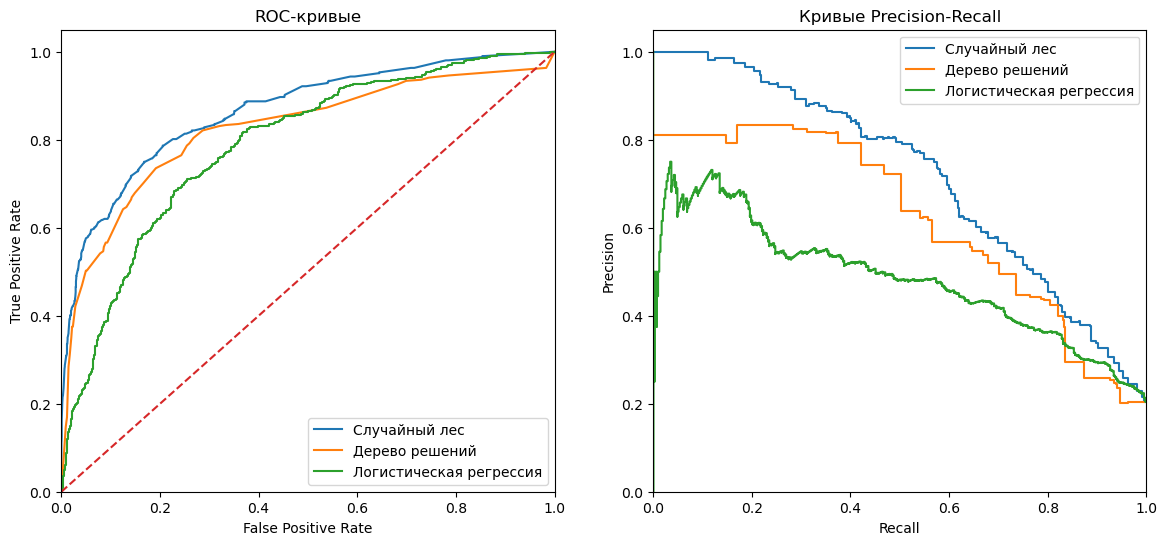

In [22]:
goodness_of_fit_and_roc_auc(features_train, target_train, features_valid, target_valid)

Лучше всех по всем параметрам показателям себя модель "Случайный лес" с глубиной 22 и количеством деревьев 90:

1. **F-1 score** == 0.629412	
2. **ROC AUC score** == 0.865156

Посмотрим, удастся ли улучшить показатели с помощью перебалансировки выборки.

## Шаг 3 Борьба с дисбалансом

### 3.1 Подготовка выборок

Воспользуемся двумя методами -- upsample и downsample с frac равным 4 и 0,25 соответственно.

Так как у нас нет "мусорных" данных, так как каждая строчка -- это уникальный клиент Банка, то разумнее в первую очередь использовать upsample.

Но мы попробуем и то, и то.

In [23]:
# делим выборку на отрицательные и положительные объекты

features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

# делаем апсемплинг в четыре раза и перемешиваем
features_upsampled = pd.concat([features_zeros] + [features_ones] * 4)
target_upsampled = pd.concat([target_zeros] + [target_ones] * 4)
    
features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=RAND_FIX)

# делаем даунсемплинг в четыре раза и перемешиваем
features_downsampled = pd.concat([features_zeros.sample(frac=0.25, random_state=RAND_FIX)] + [features_ones])
target_downsampled = pd.concat([target_zeros.sample(frac=0.25, random_state=RAND_FIX)] + [target_ones])
    
features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=RAND_FIX)

# Выводим результат
print('features_upsampled:', features_upsampled.shape, ' target_upsampled:', target_upsampled.shape)
print('Относительная мощность положительного класса после upsample --', target_upsampled.mean())
print('Относительная мощность отрицательного класса после upsample --', 1 - target_upsampled.mean(), end='\n\n')
print('features_downsampled:', features_downsampled.shape, ' target_downsampled:', target_downsampled.shape)
print('Относительная мощность положительного класса после downsample --', target_downsampled.mean())
print('Относительная мощность отрицательного класса после downsample --', 1 - target_downsampled.mean())

features_upsampled: (9666, 11)  target_upsampled: (9666,)
Относительная мощность положительного класса после upsample -- 0.5056900475894889
Относительная мощность отрицательного класса после upsample -- 0.4943099524105111

features_downsampled: (2416, 11)  target_downsampled: (2416,)
Относительная мощность положительного класса после downsample -- 0.5057947019867549
Относительная мощность отрицательного класса после downsample -- 0.4942052980132451


### 3.2 Проверка после upsample

Смотрим, как вариант с апсемплингом покажет себя на моделях:

Результаты исследования моделей:


,Глубина,Кол-во деревьев,Время обучения,Алгоритм,f-1 score,ROC AUC score
Случайный лес,10.0,30.0,0.193089,NaN,0.651113,0.866455
Дерево решений,6.0,NaN,0.018000,NaN,0.575926,0.823342
Логистическая регрессия,NaN,NaN,0.010001,liblinear,0.524675,0.793777


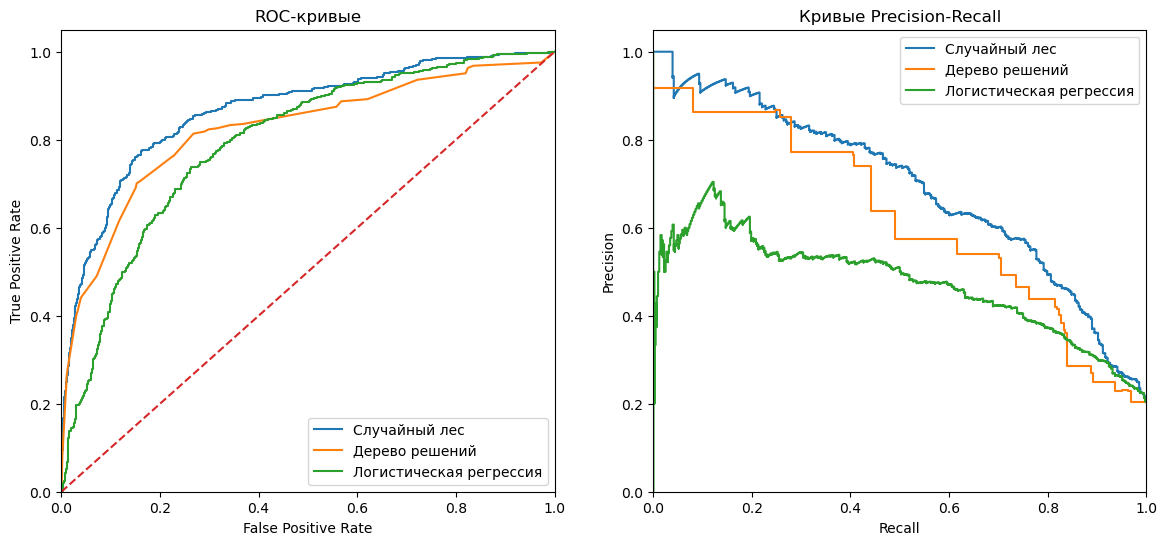

In [24]:
goodness_of_fit_and_roc_auc(features_upsampled, target_upsampled, features_valid, target_valid)

Лучше всех по всем параметрам показателям себя модель "Случайный лес" с глубиной 10 и количеством деревьев 30:

1. **F-1 score** == 0.651113	
2. **ROC AUC score** == 0.866455

### 3.3 Проверка после downsample

Смотрим, как вариант с даунсемплингом покажет себя на моделях:

Результаты исследования моделей:


,Глубина,Кол-во деревьев,Время обучения,Алгоритм,f-1 score,ROC AUC score
Случайный лес,7.0,30.0,0.062000,NaN,0.637512,0.865459
Дерево решений,6.0,NaN,0.005999,NaN,0.594492,0.847777
Логистическая регрессия,NaN,NaN,0.003000,liblinear,0.527586,0.792603


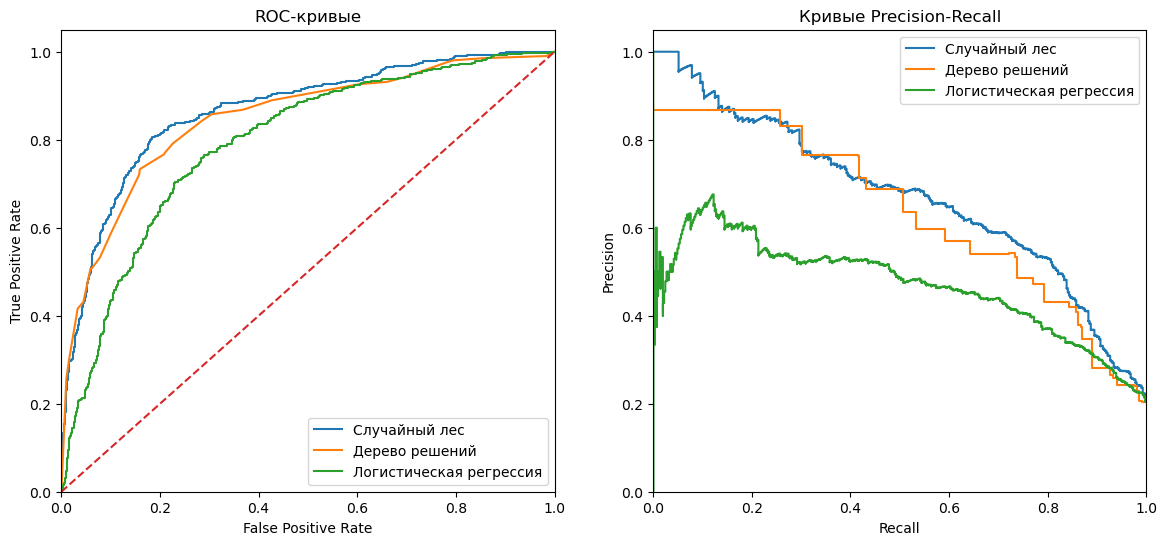

In [25]:
goodness_of_fit_and_roc_auc(features_downsampled, target_downsampled, features_valid, target_valid)

Лучше всех по всем параметрам показателям себя модель "Случайный лес" с глубиной 7 и количеством деревьев 30:

1. **F-1 score** == 0.637512
2. **ROC AUC score** == 0.865459

### 3.4 Гибридные эксперименты

Значительного улучшения не достигли, поэтому -- Эксперименты!  
Попробуем гибридный вариант. В два раза увеличим мощность "target_train == 1", в два раза уменьшим "target_train == 0"

In [26]:
# делим выборку на отрицательные и положительные объекты

features_zeros = features_train[target_train == 0]
features_ones = features_train[target_train == 1]
target_zeros = target_train[target_train == 0]
target_ones = target_train[target_train == 1]

# делаем апсемплинг в два раза, даунсемплинг в два раза и перемешиваем
features_sampled = pd.concat([features_zeros.sample(frac=0.5, random_state=RAND_FIX)] + [features_ones] * 2)
target_sampled = pd.concat([target_zeros.sample(frac=0.5, random_state=RAND_FIX)] + [target_ones] * 2)
    
features_sampled, target_sampled = shuffle(features_sampled, target_sampled, random_state=RAND_FIX)

# Выводим результат
print('features_sampled:', features_sampled.shape, ' target_sampled:', target_sampled.shape)
print('Относительная мощность положительного класса после sample --', target_sampled.mean())
print('Относительная мощность отрицательного класса после sample --', 1 - target_sampled.mean(), end='\n\n')

features_sampled: (4833, 11)  target_sampled: (4833,)
Относительная мощность положительного класса после sample -- 0.5056900475894889
Относительная мощность отрицательного класса после sample -- 0.4943099524105111



Результаты исследования моделей:


,Глубина,Кол-во деревьев,Время обучения,Алгоритм,f-1 score,ROC AUC score
Случайный лес,12.0,230.0,0.962078,NaN,0.658092,0.868466
Дерево решений,5.0,NaN,0.008999,NaN,0.591837,0.850916
Логистическая регрессия,NaN,NaN,0.004997,liblinear,0.524506,0.794167


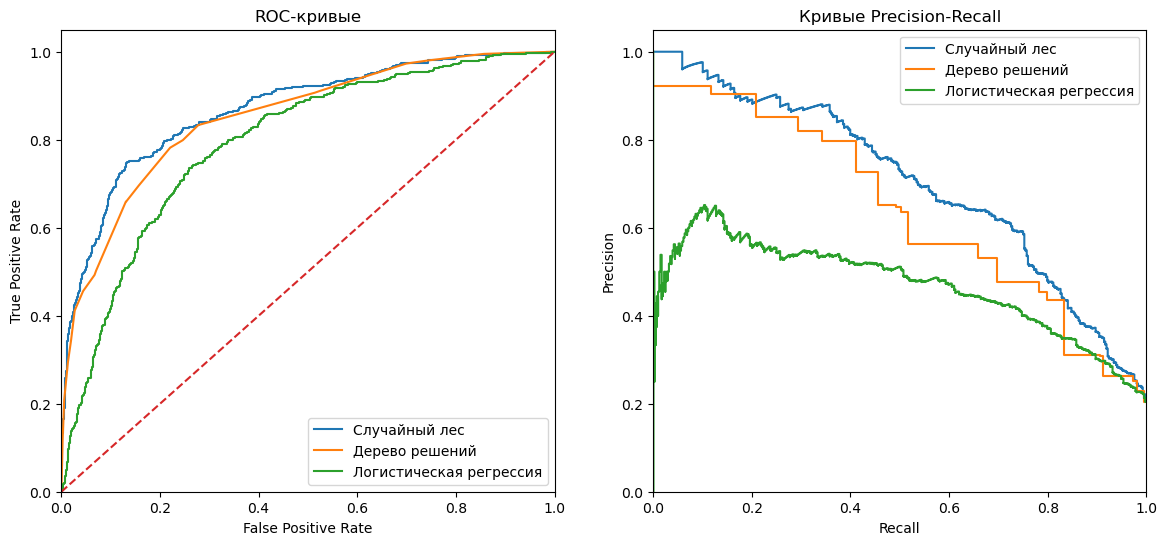

In [27]:
goodness_of_fit_and_roc_auc(features_sampled, target_sampled, features_valid, target_valid)

Лучше всех по всем параметрам показателям себя модель "Случайный лес" с глубиной 12 и количеством деревьев 230:

1. **F-1 score** == 0.658092	
2. **ROC AUC score** == 0.868466

Это лучший вариант балансировки, отдаем его на тестирование.

## Шаг 4 Тестирование модели

Проведем тестирование модели "Случайный лес", которая обучена на сбалансированной выборке с гиперпараметрами:
 - best_est_for_f = 230
 - best_depth_for_f = 12

In [28]:
best_est_for_f = 230
best_depth_for_f = 12

start_time = time.time()
best_model_for_f = RandomForestClassifier(random_state=RAND_FIX, n_estimators=best_est_for_f, max_depth=best_depth_for_f)
best_model_for_f.fit(features_sampled, target_sampled)     # Учим модель
end_time = time.time()
pred_val_f = best_model_for_f.predict(features_test)
best_result_for_f = f1_score(target_test, pred_val_f)
est_time_for_f = end_time - start_time
roc_auc_score_f = roc_auc_score(target_test, best_model_for_f.predict_proba(features_test)[:, 1])

# Отображаем результаты в табличке:
d_res = {'Глубина':[best_depth_for_f],\
        'Кол-во деревьев':[best_est_for_f],\
        'Время обучения':[est_time_for_f],\
        'f-1 score':[best_result_for_f],\
        'ROC AUC score':[roc_auc_score_f]}
df_res = pd.DataFrame(index=['Случайный лес'], \
                        data=d_res)
    
print('Результаты исследования моделей:')
display(df_res)
print('\n\n')

Результаты исследования моделей:


,Глубина,Кол-во деревьев,Время обучения,f-1 score,ROC AUC score
Случайный лес,12,230,1.00297,0.593383,0.850177


1. **F-1 score** == 0.593383	
2. **ROC AUC score** == 0.851385

Целевой показатель досигнут.

## Общий вывод

В ходе исследования:

Получены данные клиентах. О качестве данных ничего не было известно. Поэтому перед тем, как приступать к целям исследования, был подготовлен обзор данных

Проверены данные на ошибки и оценено их влияние на исследование. Затем на этапе предобработки была проведена необходимая трансформация данных. Далее набор данных был разделен в соотношении 60 - 20 - 20 на обучающую, валидационную и тестовую выборки, выделен целевой признак.

Сам анализ в свою очередь прошел в два этапа:

1. Обзор моделей на несбалансированной выборке
2. Исследование вариантов борьбы с дисбалансом для достижения максимальных метрик адексатности модели

Завершающий этап -- тестирование модели, которая показала наилучшие результаты, целевой показатель f1-score == 0.59 был достигнут.

Таким образом, исследование состояло из следующих этапов, на каждом из которых формировались выводы, которые попали в итоги исследования:

 - Обзор данных
 - Предобработка данных
 - Исследование без учета диcбаланса
 - Исследование с учетом дисбаланса
 - Тестирование

### Итоги исследования:

1. **Рекомендации в части данных**  
Предлагаю прилагать более детальное описание данных для корректной интерпретации пропусков в них.  
В столбце tenure было пропущено 10% данных, что могло помешать корректно обучить модель

2. **Результаты исследования**

    Наилучший результат получен при обучении модели "Случайный лес" с гипрепараметрами:
    - Глубина == 12
    - Количество деревьев == 230  
    Метод подготовки выборки для обучения -- одновременное применение upsampling и downsamling с к-тами 2 и 0.5 соответственно.

    На валидации:  
    - **F-1 score** == 0.658092
    - **ROC AUC score** == 0.868466

    На тестировании:  
     - **F-1 score** == 0.593383
     - **ROC AUC score** == 0.850177
    
    
Предлагаю коллегам из «Бета-Банка» использовать вышеописанную модель как один из инструментов прогнозирования оттока клиентов. 

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*